In [1]:
#Preparing Kaggle API

!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
#Download Titanic Competition Dataset

!kaggle competitions download -c titanic

  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 6.43MB/s]
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 61.2MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 27.5MB/s]


In [3]:
#Import all the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report, mean_squared_error
from sklearn.model_selection import GridSearchCV
import xgboost
import seaborn as sns

In [4]:
#Read the train data

df_train = pd.read_csv('train.csv')
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
#Read the Test Data

df_test = pd.read_csv('test.csv')
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [6]:
#Drop the unuse columns

df_train = df_train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
df_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


In [7]:
#Print the info of the train dataset

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [8]:
#Print the info of the test dataset

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [9]:
#Rearange the column

end = ['Age', 'Fare', 'Sex', 'Embarked']
df_train = df_train[[i for i in df_train if i not in end] 
        + [i for i in end if i in df_train]]
df_train

,Survived,Pclass,SibSp,Parch,Age,Fare,Sex,Embarked
0,0,3,1,0,22.0,7.2500,male,S
1,1,1,1,0,38.0,71.2833,female,C
2,1,3,0,0,26.0,7.9250,female,S
3,1,1,1,0,35.0,53.1000,female,S
4,0,3,0,0,35.0,8.0500,male,S
...,...,...,...,...,...,...,...,...
886,0,2,0,0,27.0,13.0000,male,S
887,1,1,0,0,19.0,30.0000,female,S
888,0,3,1,2,NaN,23.4500,female,S
889,1,1,0,0,26.0,30.0000,male,C


In [10]:
#Fill NaN values of Embarked with S

df_train['Embarked'] = df_train['Embarked'].fillna('S')

In [11]:
#Print the embarked column

df_train['Embarked']

0      S
1      C
2      S
3      S
4      S
      ..
886    S
887    S
888    S
889    C
890    Q
Name: Embarked, Length: 891, dtype: object

In [12]:
#Fill NaN values of Age column with the mean of it

df_train['Age'] = df_train['Age'].fillna(df_train['Age'].mean())

In [13]:
#Encode and scaled the dataset

oe = OrdinalEncoder(dtype=np.int)
scaler = MinMaxScaler()

df_train_encoded = np.array(oe.fit_transform(df_train[['Sex', 
                                                       'Embarked']].values))
df_train_normalized = np.array(scaler.fit_transform(df_train[['Age',
                                                              'Fare']].values))
print(df_train_encoded)
print(df_train_normalized)

[[1 2]
 [0 0]
 [0 2]
 ...
 [0 2]
 [1 0]
 [1 1]]
[[0.27117366 0.01415106]
 [0.4722292  0.13913574]
 [0.32143755 0.01546857]
 ...
 [0.36792055 0.04577135]
 [0.32143755 0.0585561 ]
 [0.39683338 0.01512699]]


In [14]:
#Pick the untouch column of dataset

df_train_temp = df_train[['Survived', 'Pclass', 'SibSp', 'Parch']].to_numpy()
df_train_temp

array([[0, 3, 1, 0],
       [1, 1, 1, 0],
       [1, 3, 0, 0],
       ...,
       [0, 3, 1, 2],
       [1, 1, 0, 0],
       [0, 3, 0, 0]])

In [15]:
#Construct the dataset

df_train_fix = np.hstack([df_train_temp, df_train_normalized, df_train_encoded])
df_train_fix

array([[0.        , 3.        , 1.        , ..., 0.01415106, 1.        ,
        2.        ],
       [1.        , 1.        , 1.        , ..., 0.13913574, 0.        ,
        0.        ],
       [1.        , 3.        , 0.        , ..., 0.01546857, 0.        ,
        2.        ],
       ...,
       [0.        , 3.        , 1.        , ..., 0.04577135, 0.        ,
        2.        ],
       [1.        , 1.        , 0.        , ..., 0.0585561 , 1.        ,
        0.        ],
       [0.        , 3.        , 0.        , ..., 0.01512699, 1.        ,
        1.        ]])

In [16]:
#Make the dataset to DataFrame

df_train_fix = pd.DataFrame(df_train_fix, columns=df_train.columns, dtype=float)
df_train_fix

,Survived,Pclass,SibSp,Parch,Age,Fare,Sex,Embarked
0,0.0,3.0,1.0,0.0,0.271174,0.014151,1.0,2.0
1,1.0,1.0,1.0,0.0,0.472229,0.139136,0.0,0.0
2,1.0,3.0,0.0,0.0,0.321438,0.015469,0.0,2.0
3,1.0,1.0,1.0,0.0,0.434531,0.103644,0.0,2.0
4,0.0,3.0,0.0,0.0,0.434531,0.015713,1.0,2.0
...,...,...,...,...,...,...,...,...
886,0.0,2.0,0.0,0.0,0.334004,0.025374,1.0,2.0
887,1.0,1.0,0.0,0.0,0.233476,0.058556,0.0,2.0
888,0.0,3.0,1.0,2.0,0.367921,0.045771,0.0,2.0
889,1.0,1.0,0.0,0.0,0.321438,0.058556,1.0,0.0


In [17]:
#Check the description of the dataset

df_train_fix.describe().T

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.383838,0.486592,0.0,0.000000,0.000000,1.000000,1.0
Pclass,891.0,2.308642,0.836071,1.0,2.000000,3.000000,3.000000,3.0
SibSp,891.0,0.523008,1.102743,0.0,0.000000,0.000000,1.000000,8.0
Parch,891.0,0.381594,0.806057,0.0,0.000000,0.000000,0.000000,6.0
Age,891.0,0.367921,0.163383,0.0,0.271174,0.367921,0.434531,1.0
Fare,891.0,0.062858,0.096995,0.0,0.015440,0.028213,0.060508,1.0
Sex,891.0,0.647587,0.477990,0.0,0.000000,1.000000,1.000000,1.0
Embarked,891.0,1.536476,0.791503,0.0,1.000000,2.000000,2.000000,2.0


In [18]:
#Prepare the data

X = df_train_fix.drop(['Survived'], axis=1)
X

,Pclass,SibSp,Parch,Age,Fare,Sex,Embarked
0,3.0,1.0,0.0,0.271174,0.014151,1.0,2.0
1,1.0,1.0,0.0,0.472229,0.139136,0.0,0.0
2,3.0,0.0,0.0,0.321438,0.015469,0.0,2.0
3,1.0,1.0,0.0,0.434531,0.103644,0.0,2.0
4,3.0,0.0,0.0,0.434531,0.015713,1.0,2.0
...,...,...,...,...,...,...,...
886,2.0,0.0,0.0,0.334004,0.025374,1.0,2.0
887,1.0,0.0,0.0,0.233476,0.058556,0.0,2.0
888,3.0,1.0,2.0,0.367921,0.045771,0.0,2.0
889,1.0,0.0,0.0,0.321438,0.058556,1.0,0.0


In [19]:
#Prepare the target

y = df_train_fix['Survived']
y

0      0.0
1      1.0
2      1.0
3      1.0
4      0.0
      ... 
886    0.0
887    1.0
888    0.0
889    1.0
890    0.0
Name: Survived, Length: 891, dtype: float64

In [20]:
#Find the best estimator

estimator_list = [*range(50, 401, 10)]

acc_score = []
loss_score = []
for i in estimator_list:
  print('Estimator: ', i)
  model = xgboost.XGBClassifier(n_estimators=i, random_state=23, n_jobs=-1)
  model.fit(X, y)
  X_train_predicted = model.predict(X)
  acc = accuracy_score(y, X_train_predicted)
  loss = mean_squared_error(y, X_train_predicted)
  acc_score.append(acc)
  loss_score.append(loss)
  print('Accuracy score for train data is: ', acc)
  print('MSE score for train data is: ', loss)
  print('-'*100)

Estimator:  50
Accuracy score for train data is:  0.8552188552188552
MSE score for train data is:  0.1447811447811448
----------------------------------------------------------------------------------------------------
Estimator:  60
Accuracy score for train data is:  0.8574635241301908
MSE score for train data is:  0.1425364758698092
----------------------------------------------------------------------------------------------------
Estimator:  70
Accuracy score for train data is:  0.8619528619528619
MSE score for train data is:  0.13804713804713806
----------------------------------------------------------------------------------------------------
Estimator:  80
Accuracy score for train data is:  0.8653198653198653
MSE score for train data is:  0.13468013468013468
----------------------------------------------------------------------------------------------------
Estimator:  90
Accuracy score for train data is:  0.8664421997755332
MSE score for train data is:  0.1335578002244669
----

In [21]:
#Print the best estimator

print('Best estimator is:', estimator_list[acc_score.index(max(acc_score))], 'with acc score of: ', max(acc_score), 'and MSE score of: ', min(loss_score))

Best estimator is: 390 with acc score of:  0.9214365881032548 and MSE score of:  0.07856341189674523


In [22]:
#Find the best depth

depth_list = [*range(2,11,2)]

acc_score = []
loss_score = []
for i in depth_list:
  print('Depth: ', i)
  model = xgboost.XGBClassifier(n_estimators=390, max_depth=i, 
                                random_state=23, n_jobs=-1)
  model.fit(X, y)
  X_train_predicted = model.predict(X)
  acc = accuracy_score(y, X_train_predicted)
  loss = mean_squared_error(y, X_train_predicted)
  acc_score.append(acc)
  loss_score.append(loss)
  print('Accuracy score for train data is: ', acc)
  print('MSE score for train data is: ', loss)
  print('-'*100)

Depth:  2
Accuracy score for train data is:  0.8877665544332211
MSE score for train data is:  0.1122334455667789
----------------------------------------------------------------------------------------------------
Depth:  4
Accuracy score for train data is:  0.9405162738496072
MSE score for train data is:  0.05948372615039282
----------------------------------------------------------------------------------------------------
Depth:  6
Accuracy score for train data is:  0.9652076318742986
MSE score for train data is:  0.03479236812570146
----------------------------------------------------------------------------------------------------
Depth:  8
Accuracy score for train data is:  0.9764309764309764
MSE score for train data is:  0.02356902356902357
----------------------------------------------------------------------------------------------------
Depth:  10
Accuracy score for train data is:  0.9797979797979798
MSE score for train data is:  0.020202020202020204
-------------------------

In [23]:
#Print the best depth

print('Best depth is:', depth_list[acc_score.index(max(acc_score))], 'with acc score of: ', max(acc_score), 'and MSE score of: ', min(loss_score))

Best depth is: 10 with acc score of:  0.9797979797979798 and MSE score of:  0.020202020202020204


In [24]:
#Fit the model with the best params

model = xgboost.XGBClassifier(n_estimators=390, max_depth=10, 
                                random_state=23, n_jobs=-1)
model.fit(X, y)
X_train_predicted = model.predict(X)
acc = accuracy_score(y, X_train_predicted)
loss = mean_squared_error(y, X_train_predicted)
print('Accuracy score for train data is: ', acc)
print('MSE score for train data is: ', loss)

Accuracy score for train data is:  0.9797979797979798
MSE score for train data is:  0.020202020202020204


In [25]:
#Print classification report

print(classification_report(y, X_train_predicted))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       549
         1.0       0.98      0.97      0.97       342

    accuracy                           0.98       891
   macro avg       0.98      0.98      0.98       891
weighted avg       0.98      0.98      0.98       891



Text(0.5, 1.0, 'Confusion Matrix of Titanic Dataset using\nXGBoost')

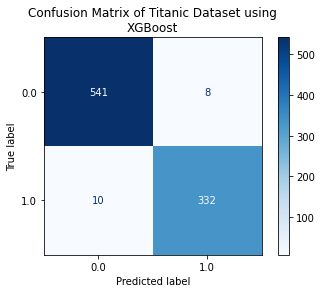

In [26]:
#Print the Confusion Matrix

disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X,
        y,
        cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix of Titanic Dataset using'+ 
                   '\nXGBoost')

### Test Dataset

In [27]:
#Preprocess the test dataset

df_test_2 = df_test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
df_test_2['Age'] = df_test_2['Age'].fillna(df_test_2['Age'].mean())
df_test_2['Fare'] = df_test_2['Fare'].fillna(df_test_2['Fare'].mean())
print(df_test_2)
df_test_2.info()

     Pclass     Sex       Age  SibSp  Parch      Fare Embarked
0         3    male  34.50000      0      0    7.8292        Q
1         3  female  47.00000      1      0    7.0000        S
2         2    male  62.00000      0      0    9.6875        Q
3         3    male  27.00000      0      0    8.6625        S
4         3  female  22.00000      1      1   12.2875        S
..      ...     ...       ...    ...    ...       ...      ...
413       3    male  30.27259      0      0    8.0500        S
414       1  female  39.00000      0      0  108.9000        C
415       3    male  38.50000      0      0    7.2500        S
416       3    male  30.27259      0      0    8.0500        S
417       3    male  30.27259      1      1   22.3583        C

[418 rows x 7 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  

In [28]:
#Rearange the test data columns

end = ['Age', 'Fare', 'Sex', 'Embarked']
df_test_2 = df_test_2[[i for i in df_test_2 if i not in end] 
        + [i for i in end if i in df_test_2]]
df_test_2

,Pclass,SibSp,Parch,Age,Fare,Sex,Embarked
0,3,0,0,34.50000,7.8292,male,Q
1,3,1,0,47.00000,7.0000,female,S
2,2,0,0,62.00000,9.6875,male,Q
3,3,0,0,27.00000,8.6625,male,S
4,3,1,1,22.00000,12.2875,female,S
...,...,...,...,...,...,...,...
413,3,0,0,30.27259,8.0500,male,S
414,1,0,0,39.00000,108.9000,female,C
415,3,0,0,38.50000,7.2500,male,S
416,3,0,0,30.27259,8.0500,male,S


In [29]:
#Encode and scaled the test dataset

df_test_encoded = np.array(oe.transform(df_test_2[['Sex', 
                                                       'Embarked']].values))
df_test_normalized = np.array(scaler.transform(df_test_2[['Age',
                                                              'Fare']].values))
print(df_test_encoded)
print(df_test_normalized)

[[1 1]
 [0 2]
 [1 1]
 [1 2]
 [0 2]
 [1 2]
 [0 1]
 [1 2]
 [0 0]
 [1 2]
 [1 2]
 [1 2]
 [0 2]
 [1 2]
 [0 2]
 [0 0]
 [1 1]
 [1 0]
 [0 2]
 [0 0]
 [1 0]
 [1 2]
 [0 2]
 [1 0]
 [0 0]
 [1 2]
 [0 0]
 [1 0]
 [1 2]
 [1 0]
 [1 2]
 [1 2]
 [0 2]
 [0 2]
 [1 0]
 [1 0]
 [0 2]
 [0 2]
 [1 2]
 [1 2]
 [1 0]
 [1 2]
 [1 2]
 [0 2]
 [0 2]
 [1 2]
 [1 0]
 [1 1]
 [0 0]
 [0 2]
 [1 2]
 [1 0]
 [0 2]
 [0 2]
 [1 0]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [0 0]
 [1 2]
 [1 2]
 [1 2]
 [0 1]
 [1 0]
 [0 2]
 [0 1]
 [1 2]
 [1 0]
 [0 2]
 [0 1]
 [1 2]
 [0 2]
 [1 0]
 [0 0]
 [1 0]
 [1 2]
 [0 2]
 [1 2]
 [0 1]
 [1 0]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 0]
 [0 1]
 [0 2]
 [0 1]
 [1 2]
 [0 2]
 [1 2]
 [0 2]
 [1 2]
 [1 0]
 [1 2]
 [0 2]
 [1 2]
 [0 2]
 [1 2]
 [0 0]
 [1 2]
 [1 1]
 [1 2]
 [0 0]
 [1 2]
 [1 1]
 [1 1]
 [1 2]
 [1 2]
 [1 0]
 [0 1]
 [0 0]
 [0 1]
 [0 2]
 [1 0]
 [1 0]
 [0 2]
 [1 0]
 [0 2]
 [0 2]
 [1 1]
 [0 0]
 [1 2]
 [1 1]
 [0 2]
 [1 2]
 [0 1]
 [1 2]
 [1 2]
 [1 2]
 [1 0]
 [0 2]
 [1 0]
 [1 2]
 [1 2]
 [1 0]
 [1 2]
 [0 2]
 [1 2]
 [0 2]
 [0 2]
 [1 0]

In [30]:
#Pick the untouch test dataset

df_test_temp = df_test_2[['Pclass', 'SibSp', 'Parch']].to_numpy()
df_test_temp

array([[3, 0, 0],
       [3, 1, 0],
       [2, 0, 0],
       ...,
       [3, 0, 0],
       [3, 0, 0],
       [3, 1, 1]])

In [31]:
#Construct the test dataset

df_test_fix = np.hstack([df_test_temp, df_test_normalized, df_test_encoded])
df_test_fix

array([[3.        , 0.        , 0.        , ..., 0.01528158, 1.        ,
        1.        ],
       [3.        , 1.        , 0.        , ..., 0.01366309, 0.        ,
        2.        ],
       [2.        , 0.        , 0.        , ..., 0.01890874, 1.        ,
        1.        ],
       ...,
       [3.        , 0.        , 0.        , ..., 0.01415106, 1.        ,
        2.        ],
       [3.        , 0.        , 0.        , ..., 0.01571255, 1.        ,
        2.        ],
       [3.        , 1.        , 1.        , ..., 0.0436405 , 1.        ,
        0.        ]])

In [32]:
#Make DataFrame from test dataset

df_test_fix = pd.DataFrame(df_test_fix, columns=df_test_2.columns, dtype=float)
df_test_fix

,Pclass,SibSp,Parch,Age,Fare,Sex,Embarked
0,3.0,0.0,0.0,0.428248,0.015282,1.0,1.0
1,3.0,1.0,0.0,0.585323,0.013663,0.0,2.0
2,2.0,0.0,0.0,0.773813,0.018909,1.0,1.0
3,3.0,0.0,0.0,0.334004,0.016908,1.0,2.0
4,3.0,1.0,1.0,0.271174,0.023984,0.0,2.0
...,...,...,...,...,...,...,...
413,3.0,0.0,0.0,0.375127,0.015713,1.0,2.0
414,1.0,0.0,0.0,0.484795,0.212559,0.0,0.0
415,3.0,0.0,0.0,0.478512,0.014151,1.0,2.0
416,3.0,0.0,0.0,0.375127,0.015713,1.0,2.0


In [33]:
#Predict the test data

y_test_predict = model.predict(df_test_fix)

In [34]:
#Print the predicted test data

y_test_predict

array([0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 1., 1., 0.

In [35]:
#Pick the PassengerId column

passenger_id = df_test['PassengerId'].to_numpy()
passenger_id

array([ 892,  893,  894,  895,  896,  897,  898,  899,  900,  901,  902,
        903,  904,  905,  906,  907,  908,  909,  910,  911,  912,  913,
        914,  915,  916,  917,  918,  919,  920,  921,  922,  923,  924,
        925,  926,  927,  928,  929,  930,  931,  932,  933,  934,  935,
        936,  937,  938,  939,  940,  941,  942,  943,  944,  945,  946,
        947,  948,  949,  950,  951,  952,  953,  954,  955,  956,  957,
        958,  959,  960,  961,  962,  963,  964,  965,  966,  967,  968,
        969,  970,  971,  972,  973,  974,  975,  976,  977,  978,  979,
        980,  981,  982,  983,  984,  985,  986,  987,  988,  989,  990,
        991,  992,  993,  994,  995,  996,  997,  998,  999, 1000, 1001,
       1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012,
       1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023,
       1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034,
       1035, 1036, 1037, 1038, 1039, 1040, 1041, 10

In [36]:
#Construct the submission array

submission = np.hstack([passenger_id.reshape(-1,1), y_test_predict.reshape(-1,1)]).astype(int)
submission

array([[ 892,    0],
       [ 893,    0],
       [ 894,    1],
       [ 895,    1],
       [ 896,    1],
       [ 897,    0],
       [ 898,    0],
       [ 899,    0],
       [ 900,    1],
       [ 901,    0],
       [ 902,    0],
       [ 903,    0],
       [ 904,    1],
       [ 905,    0],
       [ 906,    1],
       [ 907,    1],
       [ 908,    0],
       [ 909,    1],
       [ 910,    1],
       [ 911,    0],
       [ 912,    0],
       [ 913,    0],
       [ 914,    1],
       [ 915,    1],
       [ 916,    1],
       [ 917,    0],
       [ 918,    1],
       [ 919,    0],
       [ 920,    1],
       [ 921,    0],
       [ 922,    0],
       [ 923,    0],
       [ 924,    1],
       [ 925,    0],
       [ 926,    1],
       [ 927,    0],
       [ 928,    0],
       [ 929,    0],
       [ 930,    0],
       [ 931,    1],
       [ 932,    0],
       [ 933,    0],
       [ 934,    0],
       [ 935,    1],
       [ 936,    1],
       [ 937,    0],
       [ 938,    0],
       [ 939,

In [37]:
#Make DataFrame from the submission array

submission = pd.DataFrame(submission, columns = ['PassengerId', 'Survived'])
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,1
3,895,1
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [38]:
#Make the csv file submission

submission.to_csv('./submission.csv', index=False)

In [39]:
#Submit the file

!kaggle competitions submit -c titanic -f submission.csv -m "First Submit using XGBoost"

100% 2.77k/2.77k [00:00<00:00, 13.2kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster

The model got accuracy of 75.12% on the test data

# Try with default parameter

In [40]:
#Fit the model with the best params

model = xgboost.XGBClassifier(random_state=23, n_jobs=-1)
model.fit(X, y)
X_train_predicted = model.predict(X)
acc = accuracy_score(y, X_train_predicted)
loss = mean_squared_error(y, X_train_predicted)
print('Accuracy score for train data is: ', acc)
print('MSE score for train data is: ', loss)

Accuracy score for train data is:  0.8720538720538721
MSE score for train data is:  0.12794612794612795


In [41]:
#Print classification report

print(classification_report(y, X_train_predicted))

              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90       549
         1.0       0.89      0.77      0.82       342

    accuracy                           0.87       891
   macro avg       0.88      0.85      0.86       891
weighted avg       0.87      0.87      0.87       891



Text(0.5, 1.0, 'Confusion Matrix of Titanic Dataset using\nXGBoost')

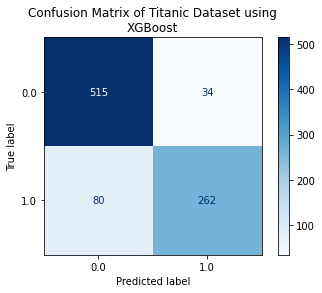

In [42]:
#Print the Confusion Matrix

disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X,
        y,
        cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix of Titanic Dataset using'+ 
                   '\nXGBoost')

### Test Dataset

In [43]:
#Preprocess the test dataset

df_test_2 = df_test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
df_test_2['Age'] = df_test_2['Age'].fillna(df_test_2['Age'].mean())
df_test_2['Fare'] = df_test_2['Fare'].fillna(df_test_2['Fare'].mean())
print(df_test_2)
df_test_2.info()

     Pclass     Sex       Age  SibSp  Parch      Fare Embarked
0         3    male  34.50000      0      0    7.8292        Q
1         3  female  47.00000      1      0    7.0000        S
2         2    male  62.00000      0      0    9.6875        Q
3         3    male  27.00000      0      0    8.6625        S
4         3  female  22.00000      1      1   12.2875        S
..      ...     ...       ...    ...    ...       ...      ...
413       3    male  30.27259      0      0    8.0500        S
414       1  female  39.00000      0      0  108.9000        C
415       3    male  38.50000      0      0    7.2500        S
416       3    male  30.27259      0      0    8.0500        S
417       3    male  30.27259      1      1   22.3583        C

[418 rows x 7 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  

In [44]:
#Rearange the test data columns

end = ['Age', 'Fare', 'Sex', 'Embarked']
df_test_2 = df_test_2[[i for i in df_test_2 if i not in end] 
        + [i for i in end if i in df_test_2]]
df_test_2

,Pclass,SibSp,Parch,Age,Fare,Sex,Embarked
0,3,0,0,34.50000,7.8292,male,Q
1,3,1,0,47.00000,7.0000,female,S
2,2,0,0,62.00000,9.6875,male,Q
3,3,0,0,27.00000,8.6625,male,S
4,3,1,1,22.00000,12.2875,female,S
...,...,...,...,...,...,...,...
413,3,0,0,30.27259,8.0500,male,S
414,1,0,0,39.00000,108.9000,female,C
415,3,0,0,38.50000,7.2500,male,S
416,3,0,0,30.27259,8.0500,male,S


In [45]:
#Encode and scaled the test dataset

df_test_encoded = np.array(oe.transform(df_test_2[['Sex', 
                                                       'Embarked']].values))
df_test_normalized = np.array(scaler.transform(df_test_2[['Age',
                                                              'Fare']].values))
print(df_test_encoded)
print(df_test_normalized)

[[1 1]
 [0 2]
 [1 1]
 [1 2]
 [0 2]
 [1 2]
 [0 1]
 [1 2]
 [0 0]
 [1 2]
 [1 2]
 [1 2]
 [0 2]
 [1 2]
 [0 2]
 [0 0]
 [1 1]
 [1 0]
 [0 2]
 [0 0]
 [1 0]
 [1 2]
 [0 2]
 [1 0]
 [0 0]
 [1 2]
 [0 0]
 [1 0]
 [1 2]
 [1 0]
 [1 2]
 [1 2]
 [0 2]
 [0 2]
 [1 0]
 [1 0]
 [0 2]
 [0 2]
 [1 2]
 [1 2]
 [1 0]
 [1 2]
 [1 2]
 [0 2]
 [0 2]
 [1 2]
 [1 0]
 [1 1]
 [0 0]
 [0 2]
 [1 2]
 [1 0]
 [0 2]
 [0 2]
 [1 0]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [0 0]
 [1 2]
 [1 2]
 [1 2]
 [0 1]
 [1 0]
 [0 2]
 [0 1]
 [1 2]
 [1 0]
 [0 2]
 [0 1]
 [1 2]
 [0 2]
 [1 0]
 [0 0]
 [1 0]
 [1 2]
 [0 2]
 [1 2]
 [0 1]
 [1 0]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 0]
 [0 1]
 [0 2]
 [0 1]
 [1 2]
 [0 2]
 [1 2]
 [0 2]
 [1 2]
 [1 0]
 [1 2]
 [0 2]
 [1 2]
 [0 2]
 [1 2]
 [0 0]
 [1 2]
 [1 1]
 [1 2]
 [0 0]
 [1 2]
 [1 1]
 [1 1]
 [1 2]
 [1 2]
 [1 0]
 [0 1]
 [0 0]
 [0 1]
 [0 2]
 [1 0]
 [1 0]
 [0 2]
 [1 0]
 [0 2]
 [0 2]
 [1 1]
 [0 0]
 [1 2]
 [1 1]
 [0 2]
 [1 2]
 [0 1]
 [1 2]
 [1 2]
 [1 2]
 [1 0]
 [0 2]
 [1 0]
 [1 2]
 [1 2]
 [1 0]
 [1 2]
 [0 2]
 [1 2]
 [0 2]
 [0 2]
 [1 0]

In [46]:
#Pick the untouch test dataset

df_test_temp = df_test_2[['Pclass', 'SibSp', 'Parch']].to_numpy()
df_test_temp

array([[3, 0, 0],
       [3, 1, 0],
       [2, 0, 0],
       ...,
       [3, 0, 0],
       [3, 0, 0],
       [3, 1, 1]])

In [47]:
#Construct the test dataset

df_test_fix = np.hstack([df_test_temp, df_test_normalized, df_test_encoded])
df_test_fix

array([[3.        , 0.        , 0.        , ..., 0.01528158, 1.        ,
        1.        ],
       [3.        , 1.        , 0.        , ..., 0.01366309, 0.        ,
        2.        ],
       [2.        , 0.        , 0.        , ..., 0.01890874, 1.        ,
        1.        ],
       ...,
       [3.        , 0.        , 0.        , ..., 0.01415106, 1.        ,
        2.        ],
       [3.        , 0.        , 0.        , ..., 0.01571255, 1.        ,
        2.        ],
       [3.        , 1.        , 1.        , ..., 0.0436405 , 1.        ,
        0.        ]])

In [48]:
#Make DataFrame from test dataset

df_test_fix = pd.DataFrame(df_test_fix, columns=df_test_2.columns, dtype=float)
df_test_fix

,Pclass,SibSp,Parch,Age,Fare,Sex,Embarked
0,3.0,0.0,0.0,0.428248,0.015282,1.0,1.0
1,3.0,1.0,0.0,0.585323,0.013663,0.0,2.0
2,2.0,0.0,0.0,0.773813,0.018909,1.0,1.0
3,3.0,0.0,0.0,0.334004,0.016908,1.0,2.0
4,3.0,1.0,1.0,0.271174,0.023984,0.0,2.0
...,...,...,...,...,...,...,...
413,3.0,0.0,0.0,0.375127,0.015713,1.0,2.0
414,1.0,0.0,0.0,0.484795,0.212559,0.0,0.0
415,3.0,0.0,0.0,0.478512,0.014151,1.0,2.0
416,3.0,0.0,0.0,0.375127,0.015713,1.0,2.0


In [49]:
#Predict the test data

y_test_predict = model.predict(df_test_fix)

In [50]:
#Print the predicted test data

y_test_predict

array([0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0.

In [51]:
#Pick the PassengerId column

passenger_id = df_test['PassengerId'].to_numpy()
passenger_id

array([ 892,  893,  894,  895,  896,  897,  898,  899,  900,  901,  902,
        903,  904,  905,  906,  907,  908,  909,  910,  911,  912,  913,
        914,  915,  916,  917,  918,  919,  920,  921,  922,  923,  924,
        925,  926,  927,  928,  929,  930,  931,  932,  933,  934,  935,
        936,  937,  938,  939,  940,  941,  942,  943,  944,  945,  946,
        947,  948,  949,  950,  951,  952,  953,  954,  955,  956,  957,
        958,  959,  960,  961,  962,  963,  964,  965,  966,  967,  968,
        969,  970,  971,  972,  973,  974,  975,  976,  977,  978,  979,
        980,  981,  982,  983,  984,  985,  986,  987,  988,  989,  990,
        991,  992,  993,  994,  995,  996,  997,  998,  999, 1000, 1001,
       1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012,
       1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023,
       1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034,
       1035, 1036, 1037, 1038, 1039, 1040, 1041, 10

In [52]:
#Construct the submission array

submission = np.hstack([passenger_id.reshape(-1,1), y_test_predict.reshape(-1,1)]).astype(int)
submission

array([[ 892,    0],
       [ 893,    0],
       [ 894,    0],
       [ 895,    0],
       [ 896,    0],
       [ 897,    0],
       [ 898,    1],
       [ 899,    0],
       [ 900,    1],
       [ 901,    0],
       [ 902,    0],
       [ 903,    0],
       [ 904,    1],
       [ 905,    0],
       [ 906,    1],
       [ 907,    1],
       [ 908,    0],
       [ 909,    0],
       [ 910,    1],
       [ 911,    0],
       [ 912,    0],
       [ 913,    1],
       [ 914,    1],
       [ 915,    1],
       [ 916,    1],
       [ 917,    0],
       [ 918,    1],
       [ 919,    0],
       [ 920,    1],
       [ 921,    0],
       [ 922,    0],
       [ 923,    0],
       [ 924,    0],
       [ 925,    0],
       [ 926,    1],
       [ 927,    0],
       [ 928,    0],
       [ 929,    0],
       [ 930,    0],
       [ 931,    0],
       [ 932,    0],
       [ 933,    0],
       [ 934,    0],
       [ 935,    1],
       [ 936,    1],
       [ 937,    0],
       [ 938,    0],
       [ 939,

In [53]:
#Make DataFrame from the submission array

submission = pd.DataFrame(submission, columns = ['PassengerId', 'Survived'])
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [54]:
#Make the csv file submission

submission.to_csv('./submission.csv', index=False)

In [55]:
#Submit the file 

!kaggle competitions submit -c titanic -f submission.csv -m "First Submit using XGBoost"

100% 2.77k/2.77k [00:00<00:00, 10.6kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster

With default parameter, the model got 77.51% of accuracy on the test dataset